In [41]:
import findspark
findspark.init()

In [3]:
# import libraries 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import plotly.graph_objs as go 
from plotly.subplots import make_subplots

from datetime import datetime, timedelta

from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.functions import avg, concat, countDistinct,\
    col, datediff, date_format, desc, \
    format_number, isnan, lag, lit, udf, split

from pyspark.ml import Pipeline 
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler 
from pyspark.sql.types import StructField, StructType, IntegerType, FloatType, StringType

from pyspark.sql.functions import split 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier 
from pyspark.ml.evaluation  import MulticlassClassificationEvaluator 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
import lightgbm as lgb

In [5]:
import configparser
import os
import logging

In [6]:

# AWS configuration 
config = configparser.ConfigParser()
config.read('config.cfg',encoding='utf-8-sig')

['config.cfg']

In [7]:

AWS_ACCESS_KEY_ID     = config.get('AWS', 'AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = config.get('AWS', 'AWS_SECRET_ACCESS_KEY')

In [8]:
S3_BUCKET = config.get('S3','DEST_S3_BUCKET')

In [9]:
spark = SparkSession \
        .builder \
        .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.2") \
        .config("fs.s3a.access.key", AWS_ACCESS_KEY_ID) \
        .config("fs.s3a.secret.key", AWS_SECRET_ACCESS_KEY) \
        .config("spark.network.timeout","10000s")\
        .config("spark.executor.heartbeatInterval","3600s")\
        .config("spark.driver.memory","40g")\
        .config("spark.executor.memory","120g")\
        .config("spark.shuffle.file.buffer", "64k")\
        .config("spark.eventLog.buffer.kb", "200k")\
        .config("spark.sql.broadcastTimeout", 7200)\
        .config("spark.master","local[12]")\
        .getOrCreate()

In [10]:
df_fact_week = spark.read.parquet(S3_BUCKET+"/user_week_summary/2018-10-01_2018-10-21")

In [11]:
# convert to pandas dataframe
df_fact_pd = df_fact_week.toPandas()

In [12]:
df_fact_pd.columns

Index(['userId', 'level', 'last_interaction', 'week_code', 'day_from_reg',
       'churn_service', 'churn_paid', 'count_login', 'time_inter_login',
       'count_song', 'count_song_weekday', 'count_song_weekend', 'count_ads',
       'ratio_song_ads', 'count_repeat', 'repeat_ratio',
       'week_avg_listen_item_session', 'total_action_week',
       'avg_num_action_session'],
      dtype='object')

In [13]:
# scale cols 
scale_cols = ['day_from_reg','count_login','time_inter_login','count_song','count_song_weekday','count_song_weekend',\
             'count_ads','ratio_song_ads','count_repeat','repeat_ratio','week_avg_listen_item_session','total_action_week','avg_num_action_session']

In [14]:
# encode cols
encode_cols = ['level','week_code']

In [15]:
import sklearn.preprocessing

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [17]:
# pd 
scaler =sklearn.preprocessing.MinMaxScaler()

df_fact_pd[scale_cols] = scaler.fit_transform(df_fact_pd[scale_cols])

In [18]:
df_fact_pd = pd.get_dummies(df_fact_pd,columns=encode_cols)

In [19]:
df_for_model = df_fact_pd.drop(columns=['userId','last_interaction'])

In [20]:
df_for_model.columns

Index(['day_from_reg', 'churn_service', 'churn_paid', 'count_login',
       'time_inter_login', 'count_song', 'count_song_weekday',
       'count_song_weekend', 'count_ads', 'ratio_song_ads', 'count_repeat',
       'repeat_ratio', 'week_avg_listen_item_session', 'total_action_week',
       'avg_num_action_session', 'level_free', 'level_paid', 'week_code_1',
       'week_code_2', 'week_code_3'],
      dtype='object')

In [21]:
df_for_model

,day_from_reg,churn_service,churn_paid,count_login,time_inter_login,count_song,count_song_weekday,count_song_weekend,count_ads,ratio_song_ads,count_repeat,repeat_ratio,week_avg_listen_item_session,total_action_week,avg_num_action_session,level_free,level_paid,week_code_1,week_code_2,week_code_3
0,0.123711,0,0,0.04,0.042017,0.090005,0.021132,0.216541,0.000000,0.0000,0.004630,0.0,0.000156,0.093778,0.053626,0,1,0,0,1
1,0.198454,1,0,0.04,0.042017,0.050759,0.022642,0.102256,0.018519,0.0050,0.000000,0.0,0.001182,0.060889,0.034729,0,1,0,1,0
2,0.157216,0,1,0.00,0.394958,0.074830,0.107925,0.000000,0.138889,0.0250,0.004630,0.0,0.000119,0.086222,0.099081,1,0,0,1,0
3,0.193299,1,0,0.16,0.031933,0.057038,0.000000,0.160902,0.009259,0.0025,0.013889,0.0,0.002232,0.094667,0.054137,0,1,0,0,1
4,0.113402,1,0,0.04,0.067227,0.070120,0.067925,0.063158,0.120370,0.0250,0.013889,0.0,0.000120,0.078667,0.044944,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53788,0.141753,0,0,0.00,0.647059,0.000000,0.000755,0.000000,0.000000,0.0000,0.000000,0.0,0.921477,0.000444,0.000511,1,0,1,0,0
53789,0.126289,0,1,0.04,0.042017,0.000000,0.000755,0.000000,0.000000,0.0000,0.000000,0.0,NaN,0.000889,0.000255,0,1,0,0,1
53790,0.100515,1,1,0.12,0.054622,0.000000,0.000755,0.000000,0.000000,0.0000,0.000000,0.0,0.000574,0.306222,0.351890,1,0,0,1,0
53791,0.175258,0,0,0.00,0.193277,0.000000,0.000755,0.000000,0.000000,0.0000,0.000000,0.0,NaN,0.000000,0.000000,1,0,1,0,0


### Modeling

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
y = df_for_model['churn_service']
X = df_for_model.drop(columns=['churn_service','churn_paid'])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [25]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [26]:
params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 20
}

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
clf = lgb.LGBMClassifier()


In [29]:
clf.set_params(**params)

LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
               boosting='gbdt', feature_fraction=0.5, is_unbalance='true',
               learning_rate=0.05, metric='auc', objective='binary',
               verbose=20)

In [30]:

clf.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)],
       verbose=20, eval_metric='logloss')

C:\Users\yng12\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Info] Number of positive: 10885, number of negative: 26770
[LightGBM] 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] 

LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
               boosting='gbdt', feature_fraction=0.5, is_unbalance='true',
               learning_rate=0.05, metric='auc', objective='binary',
               verbose=20)

In [31]:
print('Training accuracy {:.4f}'.format(clf.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(clf.score(X_test,y_test)))


Training accuracy 0.7063
Testing accuracy 0.6747


In [32]:
# predict the results
y_pred=clf.predict(X_test)

In [33]:
y_pred

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [34]:
np.sum(y_pred == 1)

5839

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

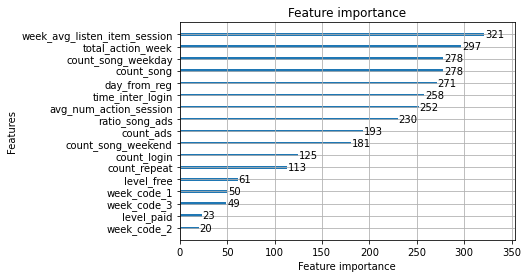

In [35]:
# feature importance
lgb.plot_importance(clf)

C:\Users\yng12\AppData\Roaming\Python\Python39\site-packages\lightgbm\plotting.py:372: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

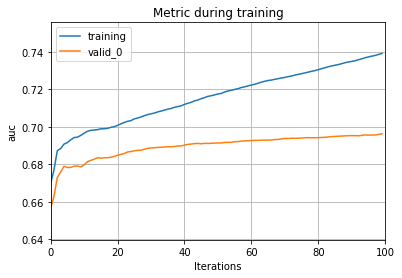

In [36]:
lgb.plot_metric(clf)

<AxesSubplot:>

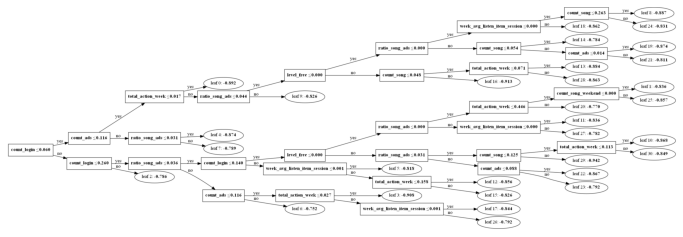

In [37]:
# tree
lgb.plot_tree(clf,figsize=(12,12))

In [38]:
from sklearn import metrics

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


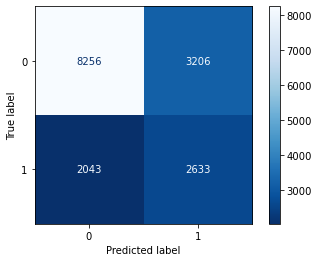

In [39]:
metrics.plot_confusion_matrix(clf,X_test,y_test,cmap='Blues_r')

In [40]:
print(metrics.classification_report(y_test,clf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.80      0.72      0.76     11462
           1       0.45      0.56      0.50      4676

    accuracy                           0.67     16138
   macro avg       0.63      0.64      0.63     16138
weighted avg       0.70      0.67      0.68     16138

